<a href="https://colab.research.google.com/github/takiwaki/Blastwave/blob/dosss/BlastwaveIntroduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このファイルを使う（パラメータ等変更）ためにはグーグルアカウントを使ってファイルからドライブにコピーを保存をする。

# Blast wave
基礎方程式は以下です。
\begin{align}
\frac{\partial \rho}{\partial t} +& \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2 \rho v_r\right) = 0,\\
\frac{\partial \rho v_r}{\partial t} +& \frac{1}{r^2}\frac{\partial }{\partial r} \left(r^2 \rho v_r v_r+r^2 p\right)= \frac{2p}{r},\\
\frac{\partial e_{\rm t}}{\partial t} +& \frac{1}{r^2}\frac{\partial }{\partial r} \left[r^2 \left(e_{\rm t}+ p\right)v_r\right]= 0,\\
    p=&  (\gamma-1) e_{\rm i}.
\end{align}
このとき全エネルギー$e_{\rm t}=e_{\rm i}+\frac{1}{2}\rho v_r^2$であり、$e_{\rm i}$は内部エネルギーです。

## Overview
時間発展をさせるためには、ソースターム `GetSrcTerm()` と `GetNumFluxHLLE()`, フラックスを評価する必要があります。初期条件は`MakeInitialConfiguration()`で作ります。

```python
  SetParameters()

  # Prepare Hydro
  InitializeVariables() 
  SetupGrids()
  MakeInitialConfiguration()
  ImposeBoundaryCondition()
  # time control
  n = 0 # initialize the step
  t = 0.0
  dt = 1.0e-2
  # Main loop begin
  for n in range(n,nmax):
  # Determine dt
    GetPressure()
    GetTimestep()
    GetSrcTerm()
    StateVector()
    GetNumFluxHLLE()
    UpdateEvoVars()
    UpdatePriVars()
    ImposeBoundaryCondition()
    n = n + 1
    t = t + dt
  # Main loop end
``` 

## Variables
変数リストは以下。
```python
  rada = np.zeros(nrad+1)  # r_a, position of cell edge
  radb = np.zeros(nrad)    # r_b, position of cell center
  dvla = np.zeros(nrad)    # dV, volume element

  rho = np.zeros(nrad)     # \rho, density
  vel = np.zeros(nrad)     # v, velocity
  pre = np.zeros(nrad)     # p, pressure
  ein = np.zeros(nrad)     # internal energy
  csp = np.zeros(nrad)     # c_s, sound speed

  rov = np.zeros(nrad)     # \rho v,  momemtum
  ett = np.zeros(nrad)     # total energy
``` 




## Code part
実際のコードは以下。単位は質量と長さと時間を表すために書いており、実際のg, cm,sではないことに注意。

In [ ]:
# Preparation for data IO
import os
import glob

# Preparation for the calcuation
import math
import numpy as np

# Preparation for the figures
import matplotlib.pyplot as plt
%matplotlib
import matplotlib.tri as tri

#  Preparation  for the animation
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
from IPython.display import Image

########################
# Set Parameters
########################
def SetParameters():
  # Physical constant

  # Parameter
  global gamma
  gamma = 4.0/3.0

  # Grid
  global radmin, radmax
  radmin = 0.0e0   # position of the inner boundary [cm]
  radmax = 1.0e0 # position of the outer boundary [cm]

  global margin, nrad
  margin = 2  # Number of margin
  nrad = 100 # Number of grid

  # time step
  global nmax
  global CFL
  CFL  = 0.25
  nmax = 1000 # maximum time step

  # Setup of data Input/Output 
  global nout
  global outputdir
  global animationfile
  nout = 10 # 
  outputdir="./snapshotsM1/"
  animationfile="aniM1.mpg"

#######################################
# Main 
#######################################
def main():
  global n
  global t, dt

  SetParameters()

  # Prepare Hydro
  InitializeVariables() 
  SetupGrids()
  MakeInitialConfiguration()
  ImposeBoundaryCondition()

  # Prepare IO
  PrepareAnimation()
  PrepareOutput(outputdir)

  # time control
  n = 0 # initialize the step
  t = 0.0
  dt = 1.0e-2

  AddPictureToAnimation() 
  ExtractKeyVariables()
  OutputSnapshot()
  # Main loop begin
  for n in range(0,nmax):
  # Determine dt
    GetPressure()
    GetTimestep()
    GetSrcTerm()
    StateVector()
    GetNumFluxHLLE()
    UpdateEvoVars()
    UpdatePriVars()
    ImposeBoundaryCondition()
    n = n + 1
    t = t + dt
    if n % nout == 0 :
      AddPictureToAnimation()
      ExtractKeyVariables()
      OutputSnapshot()
  # Main loop end
  SaveAnimation(animationfile)
  
#######################################
# Initialize coordinate and variables
#######################################

# Initialize non-dimensional coordinate and variables
def InitializeVariables():
  global rada, radb, dvla
# Initialize non-dimensional Variables
  rada = np.zeros(nrad+1)  # r_a, position of cell edge
  radb = np.zeros(nrad)    # r_b, position of cell center
  dvla = np.zeros(nrad)    # dV, volume element

  # Hydro
  global rho, pre, rov, vel, ett, ein, csp
  rho = np.zeros(nrad)     # \rho, density
  vel = np.zeros(nrad)     # v, velocity
  pre = np.zeros(nrad)     # p, pressure
  ein = np.zeros(nrad)     # internal energy
  csp = np.zeros(nrad)     # c_s, sound speed

  global rov, ett
  rov = np.zeros(nrad)     # \rho v,  momemtum
  ett = np.zeros(nrad)     # total energy

  global srcrov
  srcrov = np.zeros(nrad)     # 2 p, the source term of the momentum equation

  # Numerical flux
  global numrho, numrov, numett
  numrho = np.zeros(nrad+1)
  numrov = np.zeros(nrad+1)
  numett = np.zeros(nrad+1)

  # StateVector
  global hydstate
  hydstate = np.zeros((5,nrad))
  global leftv,rigtv
  leftv = np.zeros((5,nrad+1))
  rigtv = np.zeros((5,nrad+1))

def SetupGrids():
  global drad
  global rada
  global radb, dvla

  drad = (radmax-radmin)/(nrad - margin*2)
# uniform mesh
  rada[0] = radmin - margin * drad
  for i in range(1,nrad+1):
    rada[i] = rada[i-1] + drad
  for i in range(0,nrad):
    radb[i] = 0.5*(rada[i+1] + rada[i])
    dvla[i] = 1.0/3.0*(pow(rada[i+1],3) - pow(rada[i],3) ) # dV = (ra_i-+1^3 ra_i^3)/3 

##############################################################
# Solve Ordinary Differntial Equation for initial profile
##############################################################
def MakeInitialConfiguration():
  global rho, pre, vel
  # parameter
  neu  = 3.0
  rho0 = 1.0
  ein0 = 1.0
  # medium
  rho2 = 1.0
  pre2 = 5.0e-2
  vel2 = 0.0
  # blast wave
  dr = 8.0*(rada[margin+1]-rada[margin])
  pre1 = 3.0*(gamma-1)*ein0/(neu+1.0)/math.pi/dr**neu
  rho1 = (gamma+1)/(gamma-1)*rho2
  vel1 = (pre1/2.0*(gamma+1.0)/rho2)**0.5*2.0/(gamma+1.0) 
  for i in range(margin,nrad-margin):
    if radb[i] < dr:
      rho[i] = max(rho1*(radb[i]/dr)**(neu/(gamma-1.0)),rho2)
      pre[i] = pre1
      vel[i] = vel1*max(radb[i]/dr,0.0)
    else:
      rho[i] = rho2
      pre[i] = pre2
      vel[i] = vel2
  # consv
  global ein,rhov,ett
  ein  = pre/(gamma-1.0)
  rhov = rho*vel
  ett  = rho*vel*vel/2.0+ein

def ExtractKeyVariables():
  global rhomed
  global Eexp
  global Rshock
  global xi0
  global t
  rhomed = rho[nrad-1] 
  Eexp = 0.0
  for i in range(margin,nrad-margin):
    Eexp += (rho[i]*vel[i]**2/2+ein[i])*dvla[i]
  Eexp = Eexp *4.0*math.pi
  Rshock = 0.0
  rhomax = 0.0
  for i in range(margin,nrad-margin):
    if rhomax < rho[i]:
      rhomax = rho[i]
      Rshock = radb[i]
  if t > 0.0:
    xi0 = Rshock/(Eexp/rhomed)**(1.0/5.0)/t**(2.0/5.0)
  else:
    xi0 = (75*(gamma-1)*(gamma+1)**2/(16*math.pi)/(3*gamma-1))**(1.0/5.0)
    t   = (Rshock/(Eexp/rhomed)**(1.0/5.0)/xi0)**(5.0/2.0)
#######################################
# Solving PDE
#######################################
def GetTimestep():
  global dt
  #print("GetTimestep")
  dtmin=1.0e50
  for i in range(0,margin):
    dtloc = (rada[i+1]-rada[i])/max(abs(vel[i]),csp[i])
    dtmin = min(dtmin,dtloc)
    #print(rada[i+1],rada[i], vel[i],csp[i])
  dt = min(1.25*dt,CFL*dtmin)

def GetSrcTerm():
  global srcrov
  for i in range(0,nrad):
    srcrov[i] = 2*pre[i]

def StateVector():
  global hydstate
  # cell center 
  for i in range(0,nrad):
    hydstate[0][i] = rho[i]
    hydstate[1][i] = vel[i]
    hydstate[2][i] = ein[i]
    hydstate[3][i] = pre[i]
    hydstate[4][i] = csp[i]

def GetNumFluxHLLE():
  # cell edge
  # if nrad=100, margin=2
  # leftv should be defined at 2-98 => i 1-97
  # rigtv should be defined at 2-98 => i 2-98
  for i in range(margin-1,nrad-margin):
    for n in range(0,5):
      dsvp = hydstate[n][i+1] -  hydstate[n][i  ]
      dsvm = hydstate[n][i  ] -  hydstate[n][i-1]
      dsv  = vanLeer(dsvp,dsvm) 
      leftv[n][i+1] = hydstate[n][i]+0.5*dsv
      rigtv[n][i  ] = hydstate[n][i]-0.5*dsv

  global numrho, numrov, numett
  # Numerical flux is calculated by HLLE scheme
  # frho = rho * vel
  # frov = rho * vel * vel + pre
  # fett =  (ein+rho*vel*vel/2)*vel
  for i in range(margin,nrad-margin):
    # left and right side
    rol = leftv[0][i]
    ror = rigtv[0][i]
    vl  = leftv[1][i]
    vr  = rigtv[1][i]
    eil = leftv[2][i]
    eir = rigtv[2][i]
    prl = leftv[3][i]
    prr = rigtv[3][i]
    csl = leftv[4][i]
    csr = rigtv[4][i]
    # HLLE
    urhol = rol
    urhor = ror
    urovl = rol*vl
    urovr = ror*vr
    uettl = rol*vl*vl/2.0+eil
    uettr = ror*vr*vr/2.0+eir

    frhol = rol*vl
    frhor = ror*vr
    frovl = rol*vl*vl+prl
    frovr = ror*vr*vr+prr
    fettl = (rol*vl*vl/2.0+eil+prl)*vl
    fettr = (ror*vr*vr/2.0+eir+prr)*vr

    sl = min(vl,vr) - max(csl,csr)
    sl = min(0.0,sl) 
    sr = max(vl,vr) + max(csl,csr)
    sr = max(0.0,sr) 
    numrho[i] = (sr*frhol-sl*frhor + sr*sl*(urhor-urhol))/(sr-sl)
    numrov[i] = (sr*frovl-sl*frovr + sr*sl*(urovr-urovl))/(sr-sl)
    numett[i] = (sr*fettl-sl*fettr + sr*sl*(uettr-uettl))/(sr-sl)

def vanLeer(dvp,dvm):
  cf=2.0
  cb=2.0
  if dvp*dvm > 0.0e0 :
    dv = dvp*dvm*(cf*dvm+cb*dvp)/(dvm**2+(cf+cb-2.0e0)*dvp*dvm+dvp**2)
  else:
    dv = 0.0e0
  return dv

def UpdateEvoVars():
  global rho, rov, ett
  for i in range(margin,nrad-1-margin):
    rho[i] = rho[i]  + dt*(  numrho[i]*rada[i]*rada[i] - numrho[i+1]*rada[i+1]*rada[i+1] )/ dvla[i]
    rov[i] = rov[i]  + dt*( (numrov[i  ]-0.5*srcrov[i])*rada[i  ]*rada[i  ] \
                           -(numrov[i+1]-0.5*srcrov[i])*rada[i+1]*rada[i+1] )/ dvla[i]
    ett[i] = ett[i]  + dt*(numett[i]*rada[i]*rada[i] - numett[i+1]*rada[i+1]*rada[i+1] )/ dvla[i]
  
def UpdatePriVars():
  global vel, ein, pre, csp
# Primitive recoverly
  vel = rov/rho
  ein = ett-rho*vel*vel/2.0

def GetPressure():
  global pre, csp
  pre = ein*(gamma-1.0)
  csp = (gamma*pre/rho)**0.5

def ImposeBoundaryCondition():
  global rho, vel, ein
  # reflection boundary
  for i in range(0,margin):
    rho[i] =    rho[2*margin-1-i]
    ein[i] =    ein[2*margin-1-i]
    vel[i] =   -vel[2*margin-1-i]
  # free boundary
  for i in range(0,margin):
    rho[nrad-margin+i] =   rho[nrad-margin-1]
    ein[nrad-margin+i] =   ein[nrad-margin-1]
    vel[nrad-margin+i] =   vel[nrad-margin-1]
  

#######################################
# Setup for the animation
#######################################
def PrepareAnimation():
  global figA, artistA,ax1,ax2,ax3,ax4
# figure A
  figA = plt.figure(figsize=(12,4))
  plt.rcParams['font.size'] = 12
  artistA = []

# ax 1
  ax1 = figA.add_subplot(1,3,1)
# ax 2
  ax2 = figA.add_subplot(1,3,2)
# ax 3
  ax3 = figA.add_subplot(1,3,3)

def AddPictureToAnimation():
  global figA, artistA
  global ib1
  global im1,ax1
  global im2,ax2
# panel 1
#    im1 = ax.plot(xi,D,color='black')
  timenorm=1e3
  timetxt="t="+str(round(t*timenorm,2))+"ms"
  lb1 = ax1.text(0.6, 0.8, timetxt, transform=ax1.transAxes)
  im1 = ax1.plot(radb,rho,color='black')
#  ax1.set_xscale('log')
  ax1.set_xlabel(r"$r\,[{\rm cm}]$") 
#  ax1.set_yscale('log')
  ax1.set_ylabel(r"$\rho\,[{\rm g/cm^3}]$")

# panel 2
  im2 = ax2.plot(radb,vel,color='black')
#  ax2.set_xscale('log') 
  ax2.set_xlabel(r"$r\,[{\rm cm}]$")
  #ax2.set_yscale('log')
  ax2.set_ylabel(r"$v\,[{\rm cm/s}]$")
  ax2.set_ylim([0.0,3.0])

# panel 3
  im3 = ax3.plot(radb,pre,color='black')
#  ax2.set_xscale('log') 
  ax3.set_xlabel(r"$r\,[{\rm cm}]$")
  ax3.set_yscale('log')
  ax3.set_ylabel(r"$p\,[{\rm erg/cm^3}]$")

# add plots for animation
  figA.tight_layout()
  artistA.append(im1+im2+im3+[lb1])

# SaveAnimation
def SaveAnimation(filename):
  global animationA
  animationA = ArtistAnimation(figA,artistA,interval=10)
  animationA.save(filename, writer="ffmpeg")

#######################################
# Setup for data output
#######################################
def PrepareOutput(path):
  global new_dir_path
  global numout
  new_dir_path = path
  if not os.path.exists(new_dir_path) :
    os.mkdir(new_dir_path)
  numout = 0

def OutputSnapshot():
  #output snapshots 
  global numout
  snapfile= new_dir_path + "snap{0:05d}.dat".format(numout)
  outf= open(snapfile, 'w')
  outf.write("# time= {:.7e} \n".format(t))
  outf.write("# rho,Eexp,Rshock,xi0 {:.7e} {:.7e} {:.7e} {:.7e} \n".format(rhomed,Eexp,Rshock,xi0))
  outf.write("# 1:rad 2:den 3:vel 4:ein 5:pre 6:csp \n")
  for i in range(0,nrad):
    result = " {:.7e} {:.7e} {:.7e} {:.7e} {:.7e} {:.7e} \n".format(radb[i], rho[i], vel[i], ein[i], pre[i], csp[i])
    outf.write(result)
  outf.close()
  numout = numout+1

#######################################
# Excute Main (Do not delete!)
#######################################
if __name__ == "__main__":
  main()

# Showing annimation in HTML
HTML(animationA.to_html5_video())

Using matplotlib backend: agg


## Making snapshots

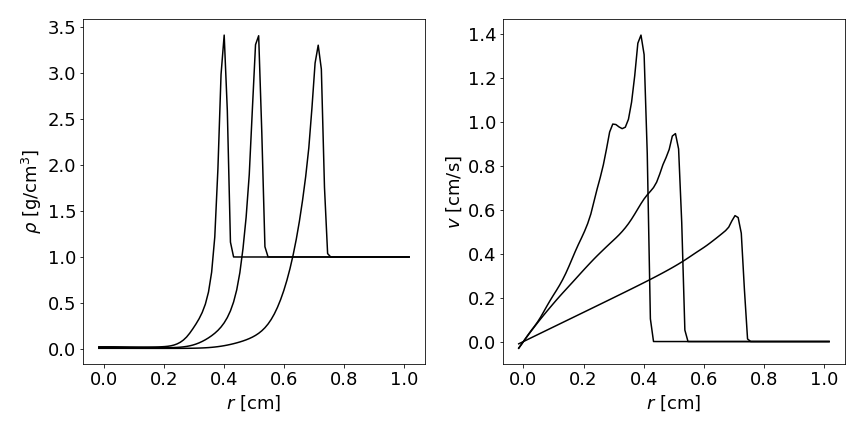

In [ ]:
#inuputlist = sorted(glob.glob('snapshotsM1/snap*.dat'))
inuputlist = [] 
inuputlist.append("snapshotsM1/snap00030.dat")
inuputlist.append("snapshotsM1/snap00050.dat")
inuputlist.append("snapshotsM1/snap00100.dat")

# figure A
figA = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 18
artistA = []
# In figure A, 2 panels
# ax 1
ax1 = figA.add_subplot(1,2,1)
# ax 2
ax2 = figA.add_subplot(1,2,2)

for input in inuputlist:
  inputf= open(input, 'r')
  header= inputf.readline() # Read the fisrtline
  item= header.split()
  t = float(item[2])
  header= inputf.readline() # Read the second line
  item= header.split()
  rhomed = float(item[2])
  Eexp   = float(item[3])
  Rshock =  float(item[4])
  xi0    =  float(item[5])
  results = np.genfromtxt(input,skip_header=3,delimiter=' ') # Read numbers
  rad, rho, vel, ein, pre,csp =  np.split(results,6,1)
  inputf.close()
  
# panel 1
#    im1 = ax.plot(xi,D,color='black')
  timetxt="t="+str(round(t,1))
#  lb1 = ax1.text(0.7, 0.7, timetxt, transform=ax1.transAxes)
  im1 = ax1.plot(rad,rho,color='black')
  #ax1.set_xscale('log')
  ax1.set_xlabel(r"$r\ [{\rm cm}]$") 
  #ax1.set_yscale('log')
  ax1.set_ylabel(r"$\rho\ [{\rm g/cm^3}]$")

# panel 2
  im2 = ax2.plot(rad,vel,color='black')
  #ax2.set_xscale('log') 
  ax2.set_xlabel(r"$r\ [{\rm cm}]$") 
  #ax2.set_yscale('log')
  ax2.set_ylabel(r"$v\ [{\rm cm/s}]$")

# add plots for animation
  figA.tight_layout()
  artistA.append(im1+im2)

figA.savefig('3snap.png')
Image(filename='3snap.png')

## Sedov solution
時間と共に形を保ちながら膨張していく解（self-similar solution）は詳細な数値計算をしなくても求めることができて便利である。
\begin{align}
\left(V-\frac{2}{5}\right)\lambda\frac{{\rm d}V}{{\rm d}\lambda}
+\frac{\lambda}{D}\frac{{\rm d}P}{{\rm d}\lambda}
=&
-V(V-1)-2\frac{P}{D},\\
\lambda\frac{{\rm d}V}{{\rm d}\lambda}
+\left(V-\frac{2}{5}\right)\frac{\lambda}{D}\frac{{\rm d}D}{{\rm d}\lambda}
=&
-3V,\\
-\left(V-\frac{2}{5}\right)\gamma\frac{\lambda}{D}\frac{{\rm d}D}{{\rm d}\lambda}
+\left(V-\frac{2}{5}\right)\frac{\lambda}{P}\frac{{\rm d}P}{{\rm d}\lambda}
=&
-2(V-1).
\end{align}
以下の式を代入すると元の方程式に戻る。
\begin{align}
\rho(r,t) = \rho_0 D(\lambda),\\
v(r,t) = r/t V(\lambda),\\
p(r,t) = \rho_0 \frac{r^2}{t^2}P(\lambda),\\
\lambda=\frac{1}{\xi_0}
 \left(\frac{\rho_{\rm med}}{E_{\rm exp}}\right)^{1/5}
rt^{-2/5}
\end{align}
解の形は$\lambda$にのみ依ることに注意。そして衝撃波のある位置を$\lambda_{\rm shock}$とすると以下のように時間発展する。
\begin{align}
r_{\rm shock}= \lambda_{\rm shock} \xi_0
\left(\frac{E_{\rm exp}}{\rho_{\rm med}}\right)^{1/5}
t^{2/5}
\end{align}
衝撃波は$t^{2/5}$で広がっていく。複雑な初期条件や時間発展をみるためには詳細な数値計算をする必要があるのに注意すること。

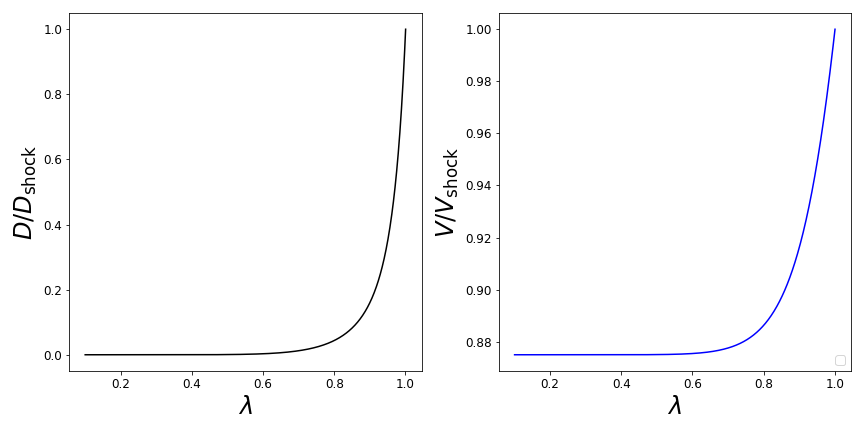

In [ ]:
########################
# Set Parameters
########################
def SetParameters():
  global gamma
  gamma = 4.0/3.0
  delta = 2.0/5.0

  global Dbd, Vbd, Pbd
# boundary condition for non-dimensional variables
  Dbd  = (gamma+1)/(gamma-1) # density at the boundary 
  Vbd  = 2.0/(gamma+1)*delta # velocity at the boundary
  Pbd  = 2.0/(gamma+1)*delta**2 # Pressure at the boundary 

  global Xmin, Xmax, margin, nX
  margin = 1   # Number of margin
  nX  = 1000   # Number of grid
  Xmin = 0.1e0 # position of the inner boundary 
  Xmax = 1.0e0 # position of the outer boundary 


#######################################
# Main 1
#######################################
def Sedov():
  SetParameters()
  InitializeVariables() # update xi, D, V
  SetupGrids()          # update dxi, xi
  ImposeBoundaryCondition()  # update ibd, D, V
  IntegrateODE() # update D, V
  FigureNonDimensional("nonD.png")
  SnapshotNonDimensional()

###############################
# Solve Ordinary Differntial Equation
###############################

# Initialize non-dimensional coordinate and variables
def InitializeVariables():
  global Xa,Xb
  Xb = np.zeros(nX)   # x, non-dimensional radius
  Xa = np.zeros(nX+1) # x, non-dimensional radius
# Initialize non-dimensional Variables
  global Dnd, Vnd, Pnd
  Dnd = np.zeros(nX) # D, non-dimensional density
  Vnd = np.zeros(nX) # V, non-dimensional velocity
  Pnd = np.zeros(nX) # P, non-dimensional pressure

def SetupGrids():
  global Xa, Xb
  # cell edge
  nonunif = False
  Xa[0] = Xmin
  # uniform mesh
  dX = (Xmax-Xmin)/(nX - margin*1)
  for i in range(1,nX+1):
    Xa[i] = Xa[i-1] + dX

  # non-uniform mesh
  if (nonunif):
    dXmin = (Xmax-Xmin)/nX/100
    eps=1.0
    C = 1.1
    while eps > 1.0e-8:
      func = C**(nX-1)-1-(Xmax-Xmin)/dXmin*(C-1)
      dfnc = (nX-1)*C**(nX-2)-(Xmax-Xmin)/dXmin
      dC   = -func/dfnc
      C    = C + dC
      eps  = abs(dC)
    Xa[0] = Xmin
    dX = dXmin
    for i in range(1,nX+1):
      Xa[i] = Xa[i-1] + dX
      dX = dX *C
    #  print (Xa[nX],Xmax) # debug
  # cell center
  for i in range(0,nX):
    Xb[i] = 0.5*(Xa[i] + Xa[i+1])

def ImposeBoundaryCondition():
  global ibd,D,V,P
# Impose the boundary condition
  ibd=nX-1
# self-similar boundary
  Dnd[ibd] = Dbd
  Vnd[ibd] = Vbd
  Pnd[ibd] = Pbd

def IntegrateODE():
  #Euler()
  RK4()

def Euler():
  VDP  = np.zeros(3)
  dVDP = np.zeros(3)
  for i in reversed(range(1,nX)):
    Xtmp = Xb[i]
    VDP = Vnd[i],Dnd[i],Pnd[i]
    #print(VDP)
    dVDP[0], dVDP[1], dVDP[2] = EvaluateDerivative(Xtmp,VDP)
    Vnd[i-1] = Vnd[i] + (Xb[i-1]-Xb[i])*dVDP[0]
    Dnd[i-1] = Dnd[i] + (Xb[i-1]-Xb[i])*dVDP[1]
    Pnd[i-1] = Pnd[i] + (Xb[i-1]-Xb[i])*dVDP[2]

def RK4():
  dVDP  = np.zeros(3)
  dVDP1 = np.zeros(3)
  dVDP2 = np.zeros(3)
  dVDP3 = np.zeros(3)
  dVDP4 = np.zeros(3)

  VDP0 = np.zeros(3)
  VDP1 = np.zeros(3)
  VDP2 = np.zeros(3)
  VDP3 = np.zeros(3)

  for i in reversed(range(1,nX)):
    Xtmp = Xb[i]
    VDP0 = Vnd[i], Dnd[i], Pnd[i]
    dVDP1[0], dVDP1[1], dVDP1[2] = EvaluateDerivative(Xtmp,VDP0)
    Xtmp = Xb[i]+0.5*(Xb[i-1]-Xb[i])
    VDP1 = VDP0 +0.5*(Xb[i-1]-Xb[i])*dVDP1
    dVDP2[0], dVDP2[1], dVDP2[2] = EvaluateDerivative(Xtmp,VDP1)
    Xtmp = Xb[i]+0.5*(Xb[i-1]-Xb[i])
    VDP2 = VDP0 +0.5*(Xb[i-1]-Xb[i])*dVDP2
    dVDP3[0], dVDP3[1], dVDP3[2] = EvaluateDerivative(Xtmp,VDP2)
    Xtmp = Xb[i]+(Xb[i-1]-Xb[i])
    VDP3 = VDP0 +(Xb[i-1]-Xb[i])*dVDP3
    dVDP4[0], dVDP4[1], dVDP4[2] = EvaluateDerivative(Xtmp,VDP3)

    dVDP = (dVDP1+2.0*dVDP2+2.0*dVDP3+dVDP4)/6.0
    Vnd[i-1] = Vnd[i] + (Xb[i-1]-Xb[i])*dVDP[0]
    Dnd[i-1] = Dnd[i] + (Xb[i-1]-Xb[i])*dVDP[1]
    Pnd[i-1] = Pnd[i] + (Xb[i-1]-Xb[i])*dVDP[2]
    #print(i)
    #print(Xb[i],V[i],D[i],P[i])

def EvaluateDerivative(Xtmp,VDP):
  Xb = Xtmp
  V,D,P =  VDP[0], VDP[1], VDP[2]
  Amat = np.zeros((3,3))
  Ainv = np.zeros((3,3))
  Bvec = np.zeros(3)
  dVDP = np.zeros(3)

  Amat[0][0] = (V-2.0/5.0)*Xb
  Amat[0][1] = 0.0
  Amat[0][2] = Xb/D
  Amat[1][0] = Xb
  Amat[1][1] = (V-2.0/5.0)*Xb/D
  Amat[1][2] = 0.0
  Amat[2][0] = 0.0
  Amat[2][1] = -(V-2.0/5.0)*Xb/D*gamma
  Amat[2][2] =  (V-2.0/5.0)*Xb/P

  Bvec[0] = -V*(V-1.0)-2.0*P/D
  Bvec[1] = -3.0*V
  Bvec[2] = -2.0*(V-1.0)
  #print ("A")
  #print (Amat)

  detA = Amat[0][0]*Amat[1][1]*Amat[2][2] \
        +Amat[0][1]*Amat[1][2]*Amat[2][0] \
        +Amat[0][2]*Amat[1][0]*Amat[2][1] \
        -Amat[0][2]*Amat[1][1]*Amat[2][0] \
        -Amat[0][1]*Amat[1][0]*Amat[2][2] \
        -Amat[0][0]*Amat[1][2]*Amat[2][1]

  Ainv[0][0] = ( Amat[1][1]*Amat[2][2]-Amat[1][2]*Amat[2][1])/detA
  Ainv[0][1] = (-Amat[0][1]*Amat[2][2]+Amat[0][2]*Amat[2][1])/detA
  Ainv[0][2] = ( Amat[0][1]*Amat[1][2]-Amat[0][2]*Amat[1][1])/detA
  Ainv[1][0] = (-Amat[1][0]*Amat[2][2]+Amat[1][2]*Amat[2][0])/detA
  Ainv[1][1] = ( Amat[0][0]*Amat[2][2]-Amat[0][2]*Amat[2][0])/detA
  Ainv[1][2] = (-Amat[0][0]*Amat[1][2]+Amat[0][2]*Amat[1][0])/detA
  Ainv[2][0] = ( Amat[1][0]*Amat[2][1]-Amat[1][1]*Amat[2][0])/detA
  Ainv[2][1] = (-Amat[0][0]*Amat[2][1]+Amat[0][1]*Amat[2][0])/detA
  Ainv[2][2] = ( Amat[0][0]*Amat[1][1]-Amat[0][1]*Amat[1][0])/detA
  #print ("Ainv")
  #print (Ainv)
  dVDP = Ainv @ Bvec
  return dVDP[0], dVDP[1], dVDP[2]

#######################################
# Setup for the figure
#######################################
def FigureNonDimensional(filename):
  global figND,ax1,ax2
  figND = plt.figure(figsize=(12,6))
  plt.rcParams['font.size'] = 12
  ax1 = figND.add_subplot(1,2,1)
  ax2 = figND.add_subplot(1,2,2)

  im1 = ax1.plot(Xb,Dnd/Dbd,color='black')
  ax1.set_xlabel(r"$\lambda$",fontsize=24)
  #ax1.set_xscale('log')
  #ax1.set_yscale('log')
  ax1.set_ylabel(r"$D/D_{\rm shock}$",fontsize=24)
  #ax1.set_xlim([1e-2,1e2])

# panel 2
  im2 = ax2.plot(Xb,Vnd/Vbd,color='blue')
  #ax2.set_xscale('log') 
  ax2.set_xlabel(r"$\lambda$",fontsize=24)
  #ax2.set_yscale('log')
  ax2.set_ylabel(r"$V/V_{\rm shock}$",fontsize=24)
  ax2.legend(loc='lower right')

# add plots for animation
  figND.tight_layout()
  figND.savefig(filename)

def SnapshotNonDimensional():
  #output snapshots 
  numout = 0
  new_dir_path = "snapshotsND/" 
  if not os.path.exists(new_dir_path) :
    os.mkdir(new_dir_path)
  snapfile= new_dir_path + "snap{0:05d}.dat".format(numout)
  outf= open(snapfile, 'w')
  outf.write("# 1:lam 2:Dmd 3:Vnd 4:Pnd \n")
  for i in range(0,nX):
    result = " {:.7e} {:.7e} {:.7e} {:.7e} \n".format(Xb[i],Dnd[i],Vnd[i],Pnd[i])
    outf.write(result)
  outf.close()

#######################################
# Excute Main (Do not delete!)
#######################################
if __name__ == "__main__":
  Sedov()
#######################################
# Showing Figures
#######################################
Image(filename="nonD.png")

### Compare the solution

詳細な数値計算はメッシュの有限な大きさにより解の形が時間発展により少し変わってしまう。また初期条件も完全なSedov解の初期条件を置くことはできない。それによって少し解の時間発展は変わってしまう。


In [ ]:
inputND ="./snapshotsND/snap00000.dat"
resultsND = np.genfromtxt(inputND,skip_header=1,delimiter=' ')
Xb, Dnd, Vnd, Pnd = np.split(resultsND,4,1)

inputlist = sorted(glob.glob('snapshotsM1/snap*.dat'))

# figure A
figA = plt.figure(figsize=(12,4))
plt.rcParams['font.size'] = 12
artistA = []
# In figure A, 2 panels
# ax 1
ax1 = figA.add_subplot(1,3,1)
# ax 2
ax2 = figA.add_subplot(1,3,2)
# ax 3
ax3 = figA.add_subplot(1,3,3)

for input in inputlist:
  inputf= open(input, 'r')
  header= inputf.readline() # Read the fisrtline
  item= header.split()
  t = float(item[2])
  header= inputf.readline() # Read the second line
  item= header.split()
  rhomed = float(item[2])
  Eexp   = float(item[3])
  Rshock =  float(item[4])
  xi0    =  float(item[5])
  #print (rhomed,Eexp,Rshock,xi0)
  results = np.genfromtxt(input,skip_header=3,delimiter=' ') # Read numbers
  rad, rho, vel, ein, pre,csp =  np.split(results,6,1)
  inputf.close()
  radsev = Xb * xi0 * (Eexp/rhomed)**(-1/5.0)*t**(2/5.0)
  rhosev = Dnd * rhomed
  velsev = Vnd * radsev/t
  presev = Pnd * rhomed*(radsev/t)**2

  timenorm=1e3
  timetxt="t="+str(round(t*timenorm,2))+"ms"
  lb1 = ax1.text(0.6, 0.8, timetxt, transform=ax1.transAxes)
  im1  = ax1.plot(radb,rho,color='black')
  im1 += ax1.plot(radsev,rhosev,color='red')
#  ax1.set_xscale('log')
  ax1.set_xlabel(r"$r\,[{\rm cm}]$") 
#  ax1.set_yscale('log')
  ax1.set_ylabel(r"$\rho\,[{\rm g/cm^3}]$")

# panel 2
  im2  = ax2.plot(radb,vel,color='black')
  im2 += ax2.plot(radsev,velsev,color='red')
#  ax2.set_xscale('log') 
  ax2.set_xlabel(r"$r\,[{\rm cm}]$")
  #ax2.set_yscale('log')
  ax2.set_ylabel(r"$v\,[{\rm cm/s}]$")
  ax2.set_ylim([0.0,3.0])

# panel 3
  im3 = ax3.plot(radb,pre,color='black')
  im3 += ax3.plot(radsev,presev,color='red')
#  ax2.set_xscale('log') 
  ax3.set_xlabel(r"$r\,[{\rm cm}]$")
  ax3.set_yscale('log')
  ax3.set_ylabel(r"$p\,[{\rm erg/cm^3}]$")

# add plots for animation
  figA.tight_layout()
  artistA.append(im1+im2+im3+[lb1])

#######################################
# Maling animation
#######################################
animationA = ArtistAnimation(figA,artistA,interval=10)

# if you want to save the animation. Uncoment this line.
animationA.save('aniAver2.mp4', writer="ffmpeg")

# Showing annimation in HTML
HTML(animationA.to_html5_video())

## space time diagram
衝撃波が$t^{2/5}$で広がっていく様はスペースタイムダイアグラムで見ることができる。


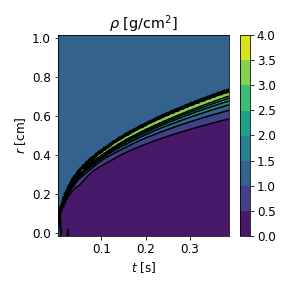

In [ ]:
inuputlist = sorted(glob.glob('snapshotsM1/snap*.dat'))

# figure B
Xtd = []
Ytd = []
Ztd = []

for input in inuputlist:
  inputf= open(input, 'r')
  header= inputf.readline() # Read the fisrtline
  item= header.split()
  t = float(item[2])
  results = np.genfromtxt(input,skip_header=3,delimiter=' ') # Read numbers
  rad, rho, vel, ein, pre,csp =  np.split(results,6,1)
  nrad=len(rad)
  inputf.close()
# for figure B, making three 2D array
  Xtd.append(t*np.ones(nrad))
  Ytd.append(rad)
  Ztd.append(rho)

#######################################
# Space Time diagram
#######################################
# 2D => 1D array
Xtd=np.array(Xtd).flatten()
Ytd=np.array(Ytd).flatten()
Ztd=np.array(Ztd).flatten()

# Triangle mesh
triang = tri.Triangulation(Xtd,Ytd)

figB = plt.figure(figsize=(4,4))
ax4 = figB.add_subplot(1,1,1)
tpc=ax4.tricontourf(triang, Ztd)
ax4.set_title(r"$\rho\ [{\rm g/cm^2}]$")
#ax4.set_xscale('log')
ax4.set_ylabel(r"$r\ [{\rm cm}]$")
#ax4.set_yscale('log')
ax4.set_xlabel(r"$t\ [{\rm s}]$")
#ax4.set_ylim([10,40])
figB.colorbar(tpc)
ax4.tricontour(triang, Ztd, colors='k')

anat = np.linspace(0.0, 0.4, 100)
anar = anat**(2/5)
#ax4.plot(anat,anar, label="analytic" ,color='white')
figB.tight_layout()

# Save the figure.
figB.savefig('t-r-rho.png')
Image(filename='t-r-rho.png') 

